## Detecting Phishing Websites Using URL-Based, HTML-Based, and Domain-Based Features

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [59]:
df2.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,-0.469464,0.002715,0,3,-0.786306,0,0,0,0,0,...,0,1,0,-0.761439,-1.799212,-1.098767,1,1,4,NaN
1,0.829801,0.468245,1,1,-0.786306,0,0,0,0,0,...,1,0,0,-0.532179,0.653026,-1.098767,0,1,2,NaN
2,1.502230,2.181040,1,4,0.912242,0,1,2,0,3,...,1,0,0,-1.165928,0.324375,1.388443,0,1,0,NaN
3,-2.181875,-1.421585,0,2,-0.786306,0,0,0,0,0,...,1,0,0,-0.628216,-1.799212,0.803570,0,0,3,NaN
4,0.282286,-0.596961,0,2,1.341682,0,0,0,0,0,...,0,1,0,0.019333,1.013862,0.417572,0,0,6,NaN


In [60]:
df2["status"].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: status, dtype: float64

In [66]:
df2['status'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 11430 entries, 0 to 11429
Series name: status
Non-Null Count  Dtype  
--------------  -----  
0 non-null      float64
dtypes: float64(1)
memory usage: 89.4 KB


In [61]:

df2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 88 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   length_url                  11430 non-null  float64
 1   length_hostname             11430 non-null  float64
 2   ip                          11430 non-null  int64  
 3   nb_dots                     11430 non-null  int64  
 4   nb_hyphens                  11430 non-null  float64
 5   nb_at                       11430 non-null  int64  
 6   nb_qm                       11430 non-null  int64  
 7   nb_and                      11430 non-null  int64  
 8   nb_or                       11430 non-null  int64  
 9   nb_eq                       11430 non-null  int64  
 10  nb_underscore               11430 non-null  int64  
 11  nb_tilde                    11430 non-null  int64  
 12  nb_percent                  11430 non-null  float64
 13  nb_slash                    114

In [62]:
df.shape

(11430, 89)

In [63]:
df2["status"].value_counts(normalize=True)  

Series([], Name: proportion, dtype: float64)

In [64]:
df2.describe().T


,count,mean,std,min,25%,50%,75%,max
length_url,11430.0,5.060208e-16,1.000044,-3.367899,-0.710053,-0.001179,0.704819,3.392894
length_hostname,11430.0,-8.497917e-16,1.000044,-4.332733,-0.596961,0.002715,0.569578,4.670642
ip,11430.0,1.505687e-01,0.357644,0.000000,0.000000,0.000000,0.000000,1.000000
nb_dots,11430.0,2.480752e+00,1.369686,1.000000,2.000000,2.000000,3.000000,24.000000
nb_hyphens,11430.0,3.419060e-18,1.000044,-0.786306,-0.786306,-0.786306,0.912242,1.856085
...,...,...,...,...,...,...,...,...
web_traffic,11430.0,-9.884190e-17,1.000044,-1.098767,-1.098767,0.154132,0.989549,1.475433
dns_record,11430.0,2.012248e-02,0.140425,0.000000,0.000000,0.000000,0.000000,1.000000
google_index,11430.0,5.339458e-01,0.498868,0.000000,0.000000,1.000000,1.000000,1.000000
page_rank,11430.0,3.185739e+00,2.536955,0.000000,1.000000,3.000000,5.000000,10.000000


count    11430.000000
mean         0.053137
std          0.089363
min          0.000000
25%          0.000000
50%          0.000000
75%          0.079365
max          0.723881
Name: ratio_digits_url, dtype: float64

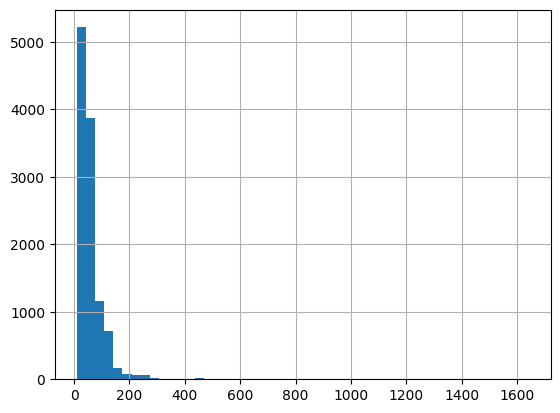

In [ ]:
df2["length_url"].hist(bins=50)
df2["nb_dots"].value_counts()
df2["ratio_digits_url"].describe()


Analysis of ratio_digits_url

The distribution of ratio_digits_url shows a pronounced right skew, with most URLs containing very few numeric characters relative to their overall length. The median sits at zero, which means at least half of all URLs include no digits at all. However, the long tail stretching toward the maximum value of approximately 0.72 reveals that a subset of URLs contains disproportionately high numeric density. This behaviour is characteristic of phishing infrastructure, where attackers frequently embed long numeric sequences to mimic session identifiers, obfuscate malicious patterns, or generate large batches of automated URLs.

Example implication:
A phishing URL such as
http://secure-login-verify-410873298.com/update/928374/confirm
exhibits a high digit ratio because both the hostname and path rely heavily on numeric padding to appear complex or legitimate.

Why this matters:
The skew indicates that while most legitimate domains remain alphanumeric with minimal digit usage, phishing URLs often inflate their numeric footprint. This separation makes ratio_digits_url a valuable discriminator for machine learning models, especially when combined with complementary lexical features like nb_dots, nb_hyphens, and length_url.

In [ ]:
df.groupby("status")[["domain_age", "domain_registration_length", "google_index"]].mean()


,domain_age,domain_registration_length,google_index
status,,,
legitimate,5093.938408,624.289939,0.169204
phishing,3031.149081,360.774453,0.898688


The comparison between legitimate and phishing domains reveals clear behavioural separation across age, registration length, and indexing patterns. Legitimate domains tend to be substantially older, with an average lifetime of more than five thousand days compared to just over three thousand for phishing sites, reflecting the long operating history typically associated with trusted organizations.

In [ ]:
for col in df2.columns:
    unique_value_list = df2[col].unique()
    if len(unique_value_list) > 10:
        print(f'{col} has {df2[col].nunique()} unique values')
    else:
        print(f'{col} contains:\t\t\t{unique_value_list}')

url has 11429 unique values
length_url has 324 unique values
length_hostname has 83 unique values
ip contains:			[0 1]
nb_dots has 19 unique values
nb_hyphens has 27 unique values
nb_at contains:			[0 1 2 3 4]
nb_qm contains:			[0 1 2 3]
nb_and has 15 unique values
nb_or contains:			[0]
nb_eq has 16 unique values
nb_underscore has 17 unique values
nb_tilde contains:			[0 1]
nb_percent has 25 unique values
nb_slash has 22 unique values
nb_star contains:			[0 1]
nb_colon contains:			[1 3 5 2 4 7]
nb_comma contains:			[0 1 2 4 3]
nb_semicolumn has 15 unique values
nb_dollar contains:			[0 1 2 3 6]
nb_space contains:			[ 0  1  3  2  5  4  6  7 18]
nb_www contains:			[1 0 2]
nb_com contains:			[0 1 2 3 6 5 4]
nb_dslash contains:			[0 1]
http_in_path contains:			[0 1 4 3 2]
https_token contains:			[1 0]
ratio_digits_url has 1414 unique values
ratio_digits_host has 241 unique values
punycode contains:			[0 1]
port contains:			[0 1]
tld_in_path contains:			[0 1]
tld_in_subdomain contains:			[0

<Axes: xlabel='status', ylabel='domain_age'>

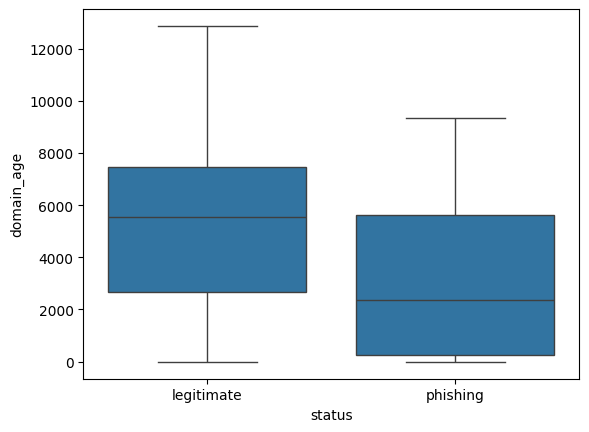

In [ ]:
sns.boxplot(data=df2, x='status', y='domain_age')


## Target Encoding

In [ ]:
df2['status'] = df2['status'].map({'legitimate': 0, 'phishing': 1})


In [ ]:
df2['status'].value_counts()


Series([], Name: count, dtype: int64)

In [ ]:
df2 = df2.drop(columns=['url'])


KeyError: "['url'] not found in axis"

In [ ]:
import pandas as pd

# Remove target
X = df2.drop(columns=['status'])
y = df2['status']

In [ ]:
# Identify numerical columns (continuous or many unique values)
numerical_cols = [col for col in X.columns if X[col].dtype != 'object' and X[col].nunique() > 20]



In phishing-URL datasets, most variables fall into three natural groups:

1. Numerical features
2. Categorical features
3. Binary features

In [ ]:
# Identify binary columns (0/1 only)
binary_cols = [col for col in X.columns 
               if X[col].nunique() == 2 and set(X[col].unique()).issubset({0,1})]

# Identify categorical columns: small number of discrete categories but not binary
categorical_cols = [col for col in X.columns 
                    if col not in numerical_cols and col not in binary_cols]

numerical_cols, binary_cols, categorical_cols[:10]  # show a sample

(['length_url',
  'length_hostname',
  'nb_hyphens',
  'nb_percent',
  'nb_slash',
  'ratio_digits_url',
  'ratio_digits_host',
  'length_words_raw',
  'char_repeat',
  'shortest_words_raw',
  'shortest_word_host',
  'shortest_word_path',
  'longest_words_raw',
  'longest_word_host',
  'longest_word_path',
  'avg_words_raw',
  'avg_word_host',
  'avg_word_path',
  'nb_hyperlinks',
  'ratio_intHyperlinks',
  'ratio_extHyperlinks',
  'nb_extCSS',
  'ratio_extRedirection',
  'ratio_extErrors',
  'links_in_tags',
  'ratio_intMedia',
  'ratio_extMedia',
  'safe_anchor',
  'domain_registration_length',
  'domain_age',
  'web_traffic'],
 ['ip',
  'nb_tilde',
  'nb_star',
  'nb_dslash',
  'https_token',
  'punycode',
  'port',
  'tld_in_path',
  'tld_in_subdomain',
  'abnormal_subdomain',
  'prefix_suffix',
  'random_domain',
  'shortening_service',
  'path_extension',
  'nb_external_redirection',
  'domain_in_brand',
  'brand_in_subdomain',
  'brand_in_path',
  'suspecious_tld',
  'login_form

The goal is to construct a preprocessing workflow that standardizes and encodes appropriately while preserving the semantic structure of each feature type
Why this pipeline works

A well-designed preprocessing chain ensures that:

Numerical features are normalized to stabilize gradient-based and distance-based models.

Binary features are passed through unchanged because scaling or encoding does not add information.

Categorical low-cardinality features can be safely one-hot encoded without inflating dimensionality.

This reduces noise, prevents feature dominance, and prepares your dataset for the most predictive models (tree ensembles, regularized linear models, and neural networks).

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import numpy as np

numerical_cols = ['length_url','length_hostname','nb_hyphens','nb_percent','nb_slash',
                  'ratio_digits_url','ratio_digits_host','length_words_raw','char_repeat',
                  'shortest_words_raw','shortest_word_host','shortest_word_path','longest_words_raw',
                  'longest_word_host','longest_word_path','avg_words_raw','avg_word_host','avg_word_path',
                  'nb_hyperlinks','ratio_intHyperlinks','ratio_extHyperlinks','nb_extCSS',
                  'ratio_extRedirection','ratio_extErrors','links_in_tags','ratio_intMedia',
                  'ratio_extMedia','safe_anchor','domain_registration_length','domain_age','web_traffic']

binary_cols = ['ip','nb_tilde','nb_star','nb_dslash','https_token','punycode','port','tld_in_path',
               'tld_in_subdomain','abnormal_subdomain','prefix_suffix','random_domain',
               'shortening_service','path_extension','nb_external_redirection','domain_in_brand',
               'brand_in_subdomain','brand_in_path','suspecious_tld','login_form','external_favicon',
               'iframe','popup_window','onmouseover','right_clic','empty_title','domain_in_title',
               'domain_with_copyright','whois_registered_domain','dns_record','google_index']

categorical_cols = ['nb_dots','nb_at','nb_qm','nb_and','nb_or','nb_eq','nb_underscore',
                    'nb_colon','nb_comma','nb_semicolumn']

# Transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

binary_transformer = 'passthrough'

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore'))
])

# Combined preprocessing
preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('bin', binary_transformer, binary_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop'
)


At this stage, the preprocessing pipeline becomes the backbone of the modeling lifecycle. Numerical values are standardized to ensure comparable scales, particularly important when features such as URL length or domain age vary by orders of magnitude. Binary indicators are preserved in their raw form to maintain interpretability and avoid unnecessary transformations. Categorical structure embedded in URL components is expressed through one-hot encoding, enabling algorithms to detect nonlinear interactions between symbolic patterns and phishing behavior. By consolidating these transformations in a unified ColumnTransformer, the pipeline guarantees reproducibility, guards against leakage, and integrates seamlessly with cross-validation and hyperparameter tuning workflows.

## MODELLING

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
df2['status'].isna().sum()


np.int64(11430)

In [ ]:
from sklearn.preprocessing import PowerTransformer

num_features = [
    'length_url', 'length_hostname', 'nb_hyphens', 'nb_percent',
    'nb_slash', 'ratio_digits_url', 'ratio_digits_host', 'length_words_raw',
    'char_repeat', 'shortest_words_raw', 'shortest_word_host',
    'shortest_word_path', 'longest_words_raw', 'longest_word_host',
    'longest_word_path', 'avg_words_raw', 'avg_word_host', 'avg_word_path',
    'nb_hyperlinks', 'ratio_intHyperlinks', 'ratio_extHyperlinks', 
    'nb_extCSS', 'ratio_extRedirection', 'ratio_extErrors', 'links_in_tags', 
    'ratio_intMedia', 'ratio_extMedia', 'safe_anchor', 'domain_registration_length',
    'domain_age', 'web_traffic'
]

pt = PowerTransformer()
df2[num_features] = pt.fit_transform(df2[num_features])


In [ ]:
# Find columns with any NaN values
nan_columns = df2.columns[df2.isna().any()]
print("Columns with NaN values:\n", nan_columns)

# Optional: see how many NaNs per column
print("\nNumber of NaNs per column:\n", df2[nan_columns].isna().sum())


Columns with NaN values:
 Index(['status'], dtype='object')

Number of NaNs per column:
 status    11430
dtype: int64


In [ ]:
df2.columns = df2.columns.str.strip()  # remove leading/trailing spaces
print(df2['status'].head())


0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: status, dtype: float64


In [69]:
df2 = df2.drop(columns=['status'])


That means we can do unsupervised modeling like clustering or dimensionality reduction to explore patterns in the data.

In [70]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df2)


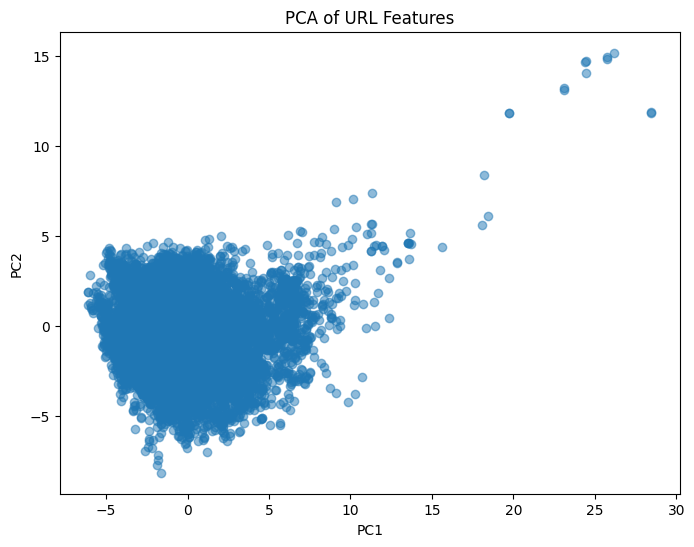

In [71]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of URL Features")
plt.show()


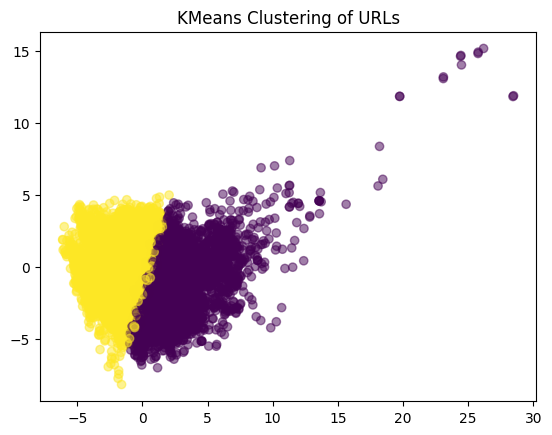

In [72]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='viridis', alpha=0.5)
plt.title("KMeans Clustering of URLs")
plt.show()


The colors represent different clusters identified by K-Means. They are unsupervised, so the algorithm doesn’t know which is phishing or legitimate yet.

Yellow points clustered from roughly -3 to 0 on the PC axis correspond to one cluster, while brown points around 5 correspond to the other cluster.

After comparing these clusters to your true labels (status), you can see which cluster mostly contains legitimate URLs and which mostly contains phishing URLs. This helps you understand how well K-Means separated the two types.

Overlapping areas indicate URLs where the algorithm finds them hard to separate, which is common because K-Means works on distance and t-SNE is only a 2D projection.